In [1]:
import tarfile
import os 

# Define the path to your tar.gz file
os.chdir('/home/jupyter-melee/')
print(os.getcwd())



/home/jupyter-melee


In [2]:
import neurokit2 as nk  
import matplotlib.pyplot as plt
def find_pqr(signal, sr):
    try:
        signals = signal.reshape(-1,)
        signals = nk.ecg_clean(signals, 250, method='neurokit') #디노이징
        _, rpeaks = nk.ecg_peaks(signals, sampling_rate = sr)
        _, waves_peak = nk.ecg_delineate(signals, rpeaks, sampling_rate = sr, method='peak')

        r_peaks = np.array(rpeaks['ECG_R_Peaks'])
        r_peaks = r_peaks[~np.isnan(r_peaks)].astype('int')

        p_peaks = np.array(waves_peak['ECG_P_Peaks'])
        p_peaks = p_peaks[~np.isnan(p_peaks)].astype('int')

        q_peaks = np.array(waves_peak['ECG_Q_Peaks'])
        q_peaks = q_peaks[~np.isnan(q_peaks)].astype('int')

        s_peaks = np.array(waves_peak['ECG_S_Peaks'])
        s_peaks = s_peaks[~np.isnan(s_peaks)].astype('int')

        t_peaks = np.array(waves_peak['ECG_T_Peaks'])
        t_peaks = t_peaks[~np.isnan(t_peaks)].astype('int')

        plt.figure(figsize=(20,6))
        plt.plot(signals)
        plt.plot(p_peaks, signals[p_peaks], "o", markersize = 6, label = 'P_peaks')
        plt.plot(q_peaks, signals[q_peaks], "o", markersize = 6, label = 'Q_peaks')
        plt.plot(r_peaks, signals[r_peaks], "o", markersize = 6, label = 'R_peaks')
        plt.plot(s_peaks, signals[s_peaks], "o", markersize = 6, label = 'S_peaks')
        plt.plot(t_peaks, signals[t_peaks], "o", markersize = 6, label = 'T_peaks')
        plt.legend()
        plt.show()
    except ValueError as e:
        print(f"ValueError: {e}")
        # 오류가 발생한 경우 NaN 배열을 반환하여 시각화 부분에서 건너뜁니다.
        return np.full_like(signal, np.nan)
 
        

Average MSE,▁
Average R-squared,▁
Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training Loss,▄█▇▄▂▃▃▅▅▄▂▃▃▄▁▂▆▃▂▄▂▄▄▃▃▄▂▂▂▁▅▃▃▁▁▁▂▂▃▃
Validation Loss,█▄▃▁▁▁▂▃▃▄▄▄▅▅
Average MSE,0.88673
Average R-squared,0.03557
Epoch,13
Training Loss,0.73849
Validation Loss,0.88518


Epoch [1/10000], Training Loss: 0.8398702144622803
Epoch [1/10000], Validation Loss: 0.8726291401045663
Epoch [2/10000], Training Loss: 1.3054330348968506
Epoch [2/10000], Validation Loss: 0.8526319095066616
Epoch [3/10000], Training Loss: 1.0982154607772827
Epoch [3/10000], Validation Loss: 0.8496351497513908
Epoch [4/10000], Training Loss: 0.8234092593193054
Epoch [4/10000], Validation Loss: 0.842013989176069
Epoch [5/10000], Training Loss: 0.8474458456039429
Epoch [5/10000], Validation Loss: 0.8428787759372166
Epoch [6/10000], Training Loss: 1.010391354560852
Epoch [6/10000], Validation Loss: 0.8391527874129159
Epoch [7/10000], Training Loss: 0.9565622210502625
Epoch [7/10000], Validation Loss: 0.8370109711374555
Epoch [8/10000], Training Loss: 0.9290397763252258
Epoch [8/10000], Validation Loss: 0.8365217617579869
Epoch [9/10000], Training Loss: 0.7787505388259888
Epoch [9/10000], Validation Loss: 0.8441735506057739
Epoch [10/10000], Training Loss: 0.8946205973625183
Epoch [10/1000

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

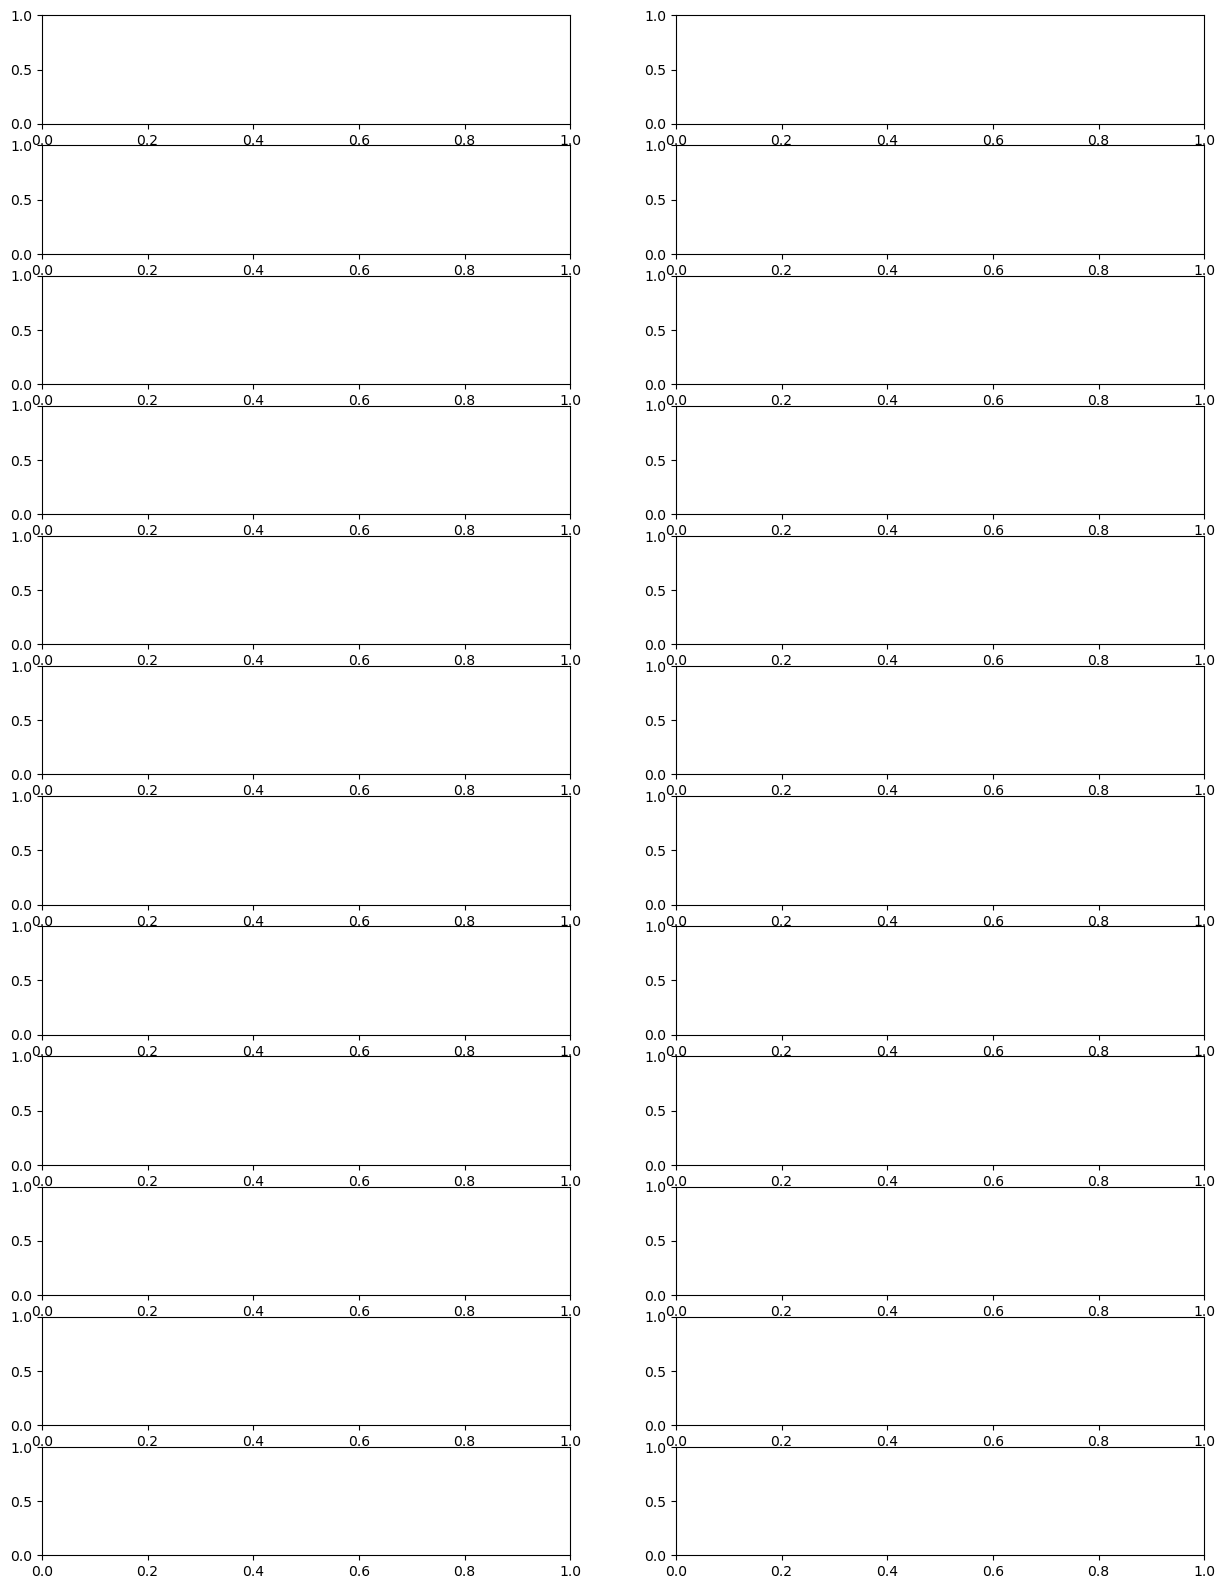

In [6]:
# CNN+linear
# 2-> 전체
# AdamP

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import butter, lfilter
from adamp import AdamP
import os
import torch.nn.functional as F
import wandb

wandb.init(project="CNNLinear_AdamP")


# 데이터 로드 및 전처리 함수
def load_npy_data(folder_path):
    X_list = []

    for file_name in os.listdir(folder_path):
        if file_name.startswith('wave') and file_name.endswith('.npy'):
            data = np.load(os.path.join(folder_path, file_name))

            if data.shape[0] == 13:
                data = data[:12, :]  # 13번째 행 제거
                
                # 디노이징을 위해 각 리드별로 nk.ecg_clean 적용
                cleaned_data = []
                for i in range(data.shape[0]):  # 각 리드에 대해 반복
                    cleaned = nk.ecg_clean(data[i, :], 250, method='neurokit')
                    cleaned_data.append(cleaned)
                cleaned_data = np.array(cleaned_data)
                X_list.append(cleaned_data)
            else:
                print(f"파일 {file_name}의 형식이 올바르지 않습니다: data shape {data.shape}")

    X = np.array(X_list)
    return X

# 이상치 제거 함수 수정
def remove_outliers(data):
    for i in range(data.shape[1]):
        q1 = np.percentile(data[:, i, :], 25, axis=1)
        q3 = np.percentile(data[:, i, :], 75, axis=1)
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        for j in range(data.shape[0]):
            data[j, i, :][data[j, i, :] < lower_bound[j]] = np.nanmedian(data[j, i, :])
            data[j, i, :][data[j, i, :] > upper_bound[j]] = np.nanmedian(data[j, i, :])
    return data

# 스무딩 함수
def apply_moving_average(data, window_size=5):
    for i in range(data.shape[1]):
        for j in range(data.shape[0]):
            data[j, i, :] = np.convolve(data[j, i, :], np.ones(window_size)/window_size, mode='same')
    return data

# 가중치 초기화 함수
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight)
        nn.init.zeros_(m.bias)

# 시각화 함수
def plot_ecgs(original, predicted, sample_index):
    fig, axes = plt.subplots(12, 2, figsize=(15, 20))
    for i in range(12):
        axes[i, 0].plot(original[sample_index, i, :])
        if i != 1:  # 2번째 리드(Lead II)는 입력 데이터이므로 제외
            axes[i, 1].plot(predicted[sample_index, i - 1 if i > 1 else i, :])
        else:
            axes[i, 1].plot(original[sample_index, i, :])  # 입력 리드(Lead II)의 원본 데이터
        axes[i, 0].set_title(f'Original Lead {i+1}')
        axes[i, 1].set_title(f'Predicted Lead {i+1}')
    plt.tight_layout()
    plt.show()


def calculate_scores(original, predicted):
    mse_scores = []
    r2_scores = []

    # 각 리드에 대한 MSE 및 R-squared 점수 계산
    for i in range(12):
        if i != 1:  # 2번째 리드(Lead II)는 입력 데이터이므로 제외
            original_lead = original[:, i, :]
            predicted_lead = predicted[:, i - 1 if i > 1 else i, :]
            mse = mean_squared_error(original_lead, predicted_lead)
            r2 = r2_score(original_lead, predicted_lead)
            mse_scores.append(mse)
            r2_scores.append(r2)
    
    return mse_scores, r2_scores        
        
# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=10, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
        else:
            self.best_loss = val_loss
            self.counter = 0 # Early Stopping

# 데이터 로드 및 전처리
folder_path = "diffusion/data_No20000/data_0"
X = load_npy_data(folder_path)

# 이상치 제거
X = remove_outliers(X)

# 스무딩
X_smoothed = apply_moving_average(X)

# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_smoothed.reshape(-1, 5000)).reshape(-1, 12, 5000)

# 텐서 변환
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# 데이터셋 분할 및 DataLoader 설정
dataset_size = len(X_tensor)
test_size = int(0.2 * dataset_size)
train_size = dataset_size - test_size
train_dataset, test_dataset = random_split(TensorDataset(X_tensor), [train_size, test_size])

# 검증 세트 분할
val_size = int(0.1 * train_size)
train_size = train_size - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

class CNNComplexRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(CNNComplexRegressionModel, self).__init__()
        # CNN 레이어 추가
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)  # 추가된 레이어
        self.pool = nn.MaxPool1d(2, 2)

        # 완전 연결 레이어
        # 풀링으로 인한 크기 조정: (input_size / 8) * 128
        self.fc1 = nn.Linear(625 * 128, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # CNN 레이어를 통과
        x = x.unsqueeze(1)  # 차원 추가 [Batch, Channel, Length]
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))  # 추가된 레이어
        x = self.pool(x)

        # 완전 연결 레이어를 통과
        x = x.view(x.size(0), -1)  # 평탄화
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        return self.fc6(x)

    


# 모델 초기화
deep_lin_reg_model = CNNComplexRegressionModel(input_size=5000, output_size=55000)
deep_lin_reg_model.apply(initialize_weights)
    
# CUDA 디바이스 설정
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
deep_lin_reg_model.to(device)
    
# 옵티마이저
params = deep_lin_reg_model.parameters()
deep_lin_reg_optimizer = AdamP(params, lr=0.001, betas=(0.9, 0.999), weight_decay=1e-2)

# EarlyStopping 인스턴스 생성
early_stopping = EarlyStopping(patience=10, verbose=True)

# Epochs 수 조정 
num_epochs = 10000


# 훈련 루프 
for epoch in range(num_epochs):
    # 훈련 부분
    deep_lin_reg_model.train()
    for data in train_loader:
        data = data[0].to(device)
        lead_II = data[:, 1, :].view(-1, 5000)
        remaining_leads = data[:, [i for i in range(12) if i != 1], :].reshape(-1, 55000)

        deep_lin_reg_optimizer.zero_grad()
        predictions = deep_lin_reg_model(lead_II)
        loss = nn.MSELoss()(predictions, remaining_leads)
        if torch.isnan(loss):
            print(f"Warning: NaN loss detected at epoch {epoch+1}")
            continue
        loss.backward()
        torch.nn.utils.clip_grad_norm_(deep_lin_reg_model.parameters(), max_norm=1.0)
        deep_lin_reg_optimizer.step()
        wandb.log({"Epoch": epoch, "Training Loss": loss.item()})
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item()}')
    
    # 10 epoch마다 평균 MSE와 R-squared 점수를 계산하고 wandb에 로깅
    if (epoch + 1) % 10 == 0:
        # 테스트 데이터셋에 대한 예측 및 점수 계산
        mse_scores, r2_scores = [], []
        deep_lin_reg_model.eval()
        with torch.no_grad():
            for data in test_loader:
                data = data[0].to(device)
                lead_II = data[:, 1, :].view(-1, 5000)
                remaining_leads = data[:, [i for i in range(12) if i != 1], :].reshape(-1, 55000)
                
                predictions = deep_lin_reg_model(lead_II)
                mse = mean_squared_error(remaining_leads.cpu().numpy(), predictions.cpu().numpy())
                r2 = r2_score(remaining_leads.cpu().numpy(), predictions.cpu().numpy())
                
                mse_scores.append(mse)
                r2_scores.append(r2)

        # 평균 점수 계산
        average_mse = np.mean(mse_scores)
        average_r2 = np.mean(r2_scores)

        # wandb에 로깅
        wandb.log({"Epoch": epoch, "Average MSE": average_mse, "Average R-squared": average_r2})

    
    # 검증 부분
    deep_lin_reg_model.eval()
    val_loss = 0
    with torch.no_grad():
        for data in val_loader:
            data = data[0].to(device)
            lead_II = data[:, 1, :].view(-1, 5000)
            remaining_leads = data[:, [i for i in range(12) if i != 1], :].reshape(-1, 55000)
            predictions = deep_lin_reg_model(lead_II)
            val_loss += nn.MSELoss()(predictions, remaining_leads).item()
    
    val_loss /= len(val_loader)
    wandb.log({"Epoch": epoch, "Validation Loss": val_loss})
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss}')

    # Early Stopping 체크
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping")
        break

mse_scores = []
r2_scores = []
        

# 테스트 데이터셋에 대한 예측
deep_lin_reg_model.eval()
with torch.no_grad():
    for data in test_loader:
        data = data[0].to(device)
        sample_data = data[0]
        lead_II = data[:, 1, :].view(-1, 5000)
        remaining_leads = data[:, [i for i in range(12) if i != 1], :].reshape(-1, 55000)
        
        predicted_output = deep_lin_reg_model(lead_II)
        # Calculate MSE and R-squared for each batch and store them
        mse = mean_squared_error(remaining_leads.cpu().numpy(), predicted_output.cpu().numpy())
        r2 = r2_score(remaining_leads.cpu().numpy(), predicted_output.cpu().numpy())

        mse_scores.append(mse)
        r2_scores.append(r2)
        
    print("Model output shape:", predicted_output.shape)        

    
    # 모델 출력 크기 확인 및 조정
    if predicted_output.shape[1] == 55000:  # 출력 크기가 55000일 때만 재구성
        predicted = predicted_output.view(-1, 11, 5000).cpu()  # Move predicted output to CPU
        sample_data_cpu = sample_data.cpu()  # Move sample data to CPU
        plot_ecgs(sample_data_cpu.numpy(), predicted.numpy(), 0)  # 첫 번째 샘플에 대한 시각화
    else:
        print("Invalid model output size")

# Compute the average of the scores
average_mse = np.mean(mse_scores)
average_r2 = np.mean(r2_scores)
            
    
wandb.log({"Average MSE": average_mse})
wandb.log({"Average R-squared": average_r2})
    
# 평균 MSE 및 R-squared 점수 출력
print(f'Average MSE: {average_mse}')
print(f'Average R-squared: {average_r2}')

